In [12]:
import json
import os
import sys

root_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '.'))
sys.path.append(root_dir)

from constants import *

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['text.usetex'] = False 


colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#C2C2F0','#FFA07A', '#B0E0E6', '#FFD700', '#D3D3D3']
patterns = ['/', 'x', 'o', 
            '\\', '+', '.', 
            '|', '-', '*']

colors = ['#34568B',  # Royal Blue
          '#FFD700',  # Gold
          '#88CCEE',  # Light Blue
          '#DDDDDD',  # Light Gray
          '#555555',  # Dark Gray
          '#FF7F00',  # Mango Orange
          '#8B4513',  # Saddle Brown
          '#2CA02C',  # Lime Green (soft enough for color blindness)
          '#AA4499']  # Soft Purple


patterns = [None, '/', 'o', None, '\\', '.', None, '|', '*']

folder= "../../../../../应用/Overleaf/" + "RL Spatial"

In [7]:
class TreeProperties:
    def __init__(self, **kwargs):
        
        self.Dimension = kwargs.get('Dimension', 0)
        self.FillFactor = kwargs.get('Fill factor', 0)
        self.IndexCapacity = kwargs.get('Index capacity', 0)
        self.LeafCapacity = kwargs.get('Leaf capacity', 0)
        self.TightMbrs = kwargs.get('Tight MBRs', 0)
        self.NearMinimumOverlapFactor = kwargs.get('Near minimum overlap factor', 0)
        self.ReinsertFactor = kwargs.get('Reinsert factor', 0)
        self.SplitDistributionFactor = kwargs.get('Split distribution factor', 0)
        self.Utilization = kwargs.get('Utilization', 0)
        self.Reads = kwargs.get('Reads', 0)
        self.Writes = kwargs.get('Writes', 0)
        self.Hits = kwargs.get('Hits', 0)
        self.Misses = kwargs.get('Misses', 0)
        self.TreeHeight = kwargs.get('Tree height', 0)
        self.NumberOfData = kwargs.get('Number of data', 0)
        self.NumberOfNodes = kwargs.get('Number of nodes', 0)
        self.Splits = kwargs.get('Splits', 0)
        self.Adjustments = kwargs.get('Adjustments', 0)
        self.QueryResults = kwargs.get('Query results', 0)
        self.BufferHits = kwargs.get('Buffer hits', 0)
        self.IndexId = kwargs.get('IndexId', 0)
        self.Status = kwargs.get('Status', 0)
        self.ElapsedTime = kwargs.get('Elapsed Time', 0)
        self.ElapsedBuildTime = kwargs.get('Elapsed Learn Time', 0)
        self.ElapsedLearnTime = kwargs.get('Elapsed Build Time', 0)
        if not self.ElapsedTime:
            # if self.ElapsedBuildTime and self.ElapsedLearnTime:
            self.ElapsedTime = self.ElapsedBuildTime + self.ElapsedLearnTime

        self.KnnQuery = kwargs.get('knn query', 0)
        self.IndexedSpace = kwargs.get('Indexed space', 0)
        self.Operations = kwargs.get('Operations', 0)
        self.IndexIo = kwargs.get('Index I/O', 0)
        self.LeafIo = kwargs.get('Leaf I/O', 0)
        
        self.QueryNum = kwargs.get('Query num', 0)
        self.QueryMean = kwargs.get('Query mean', 0)
        self.QueryVariance = kwargs.get('Query variance', 0)
        self.QueryStdDev = kwargs.get('Query stdDev', 0)
        self.QueryP50 = kwargs.get('Query p50', 0)
        self.QueryP99 = kwargs.get('Query p99', 0)

        self.InsertNum = kwargs.get('Insert num', 0)
        self.InsertMean = kwargs.get('Insert mean', 0)
        self.InsertVariance = kwargs.get('Insert variance', 0)
        self.InsertStdDev = kwargs.get('Insert stdDev', 0)
        self.InsertP50 = kwargs.get('Insert p50', 0)
        self.InsertP99 = kwargs.get('Insert p99', 0)

    def __str__(self):
        attrs = vars(self)
        return '\n'.join(f"{key}: {value}" for key, value in attrs.items())

In [13]:
def parse_rtree_properties(file_path):
    properties = {}
    
    if not os.path.exists(file_path):
        return TreeProperties(**properties)
    
    with open(file_path, 'r') as file:
        for line in file:
            if ": " in line: 
                key, value = line.strip().split(": ", 1)
                
                if value.isdigit():
                    value = int(value)
                elif value.replace('.', '', 1).isdigit():
                    value = float(value)
                properties[key] = value
    return TreeProperties(**properties)

In [15]:
# baselines = ['bmtree', 'kdtree', 'ketree_greddy', 'qdtree', 'r_star_tree', 'rankspace_zorder', 'rlrtree', 'rtree', 'zorder']
build_result_path = "../result/libspatialindex/{name}/build/"
point_result_path = "../result/libspatialindex/{name}/point/"
range_result_path = "../result/libspatialindex/{name}/range/"
knn_result_path = "../result/libspatialindex/{name}/knn/"
insert_result_path = "../result/libspatialindex/{name}/insert/"
insert_point_result_path = "../result/libspatialindex/{name}/insert_point/"

baseline_suffix = {'bmtree':'_bits_20_depth_1_sample_10000', 
                   'kdtree':'',
                   'kdtree_greedy':'',
                   'qdtree':'_episode_10_sampling_ratio_0.01_action_space_200',
                   'r_star_tree':'_rstar',
                   'rankspace_zorder':'_bits_32',
                   'rlrtree':'_rlrtree_epoch_10',
                   'rtree':'_quadratic',
                   'zorder':'_bits_32'}


In [123]:
def plot_hist(datasets, baseline_names, result, y_label="", is_log=False, title="", output_file_paths=None):
    label_size = 24
    legend_size = 20
    
    fig, ax = plt.subplots(figsize=(12, 5))
    width = 0.9 / len(baseline_names)
    x = np.arange(len(datasets))
    
    group_width = len(baseline_names) * width 
    spacing = 0.02 
    
    for i, baseline in enumerate(baseline_names):
        offset = int(i / 3) * spacing
        adjusted_x = x - int(len(baseline_names) / 2) * width + i * width + offset
        ax.bar(adjusted_x, result[i], width=width, label=baseline, color=colors[i % len(colors)], hatch=patterns[i % len(patterns)])

    ax.set_ylabel(y_label, fontsize=label_size)
    ax.set_xticks(x + spacing * (len(baseline_names) // 3 - 1) / 2) 
    ax.set_xticklabels(datasets, fontsize=label_size)
    ax.tick_params(axis='x', labelsize=label_size)
    ax.tick_params(axis='y', labelsize=label_size)

    ax.set_title(title, fontsize=label_size)
    
    if is_log:
        ax.set_yscale('log')
    
    # legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=legend_size, ncol=len(baseline_names))
    legend = ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1), fontsize=legend_size, ncol=1)
    # legend = ax.legend(loc='right', fontsize=legend_size, ncol=1)
    plt.setp(legend.get_title(), fontsize=legend_size)
    
    plt.tight_layout()
    
    if output_file_paths:
        for output_file_path in output_file_paths:
            plt.savefig(output_file_path, format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

### Read Only

#### Build

[['100%', '100%', '100%', '99%', '100%', '100%'], ['100%', '100%', '100%', '99%', '100%', '100%'], [0, 0, 0, 0, 0, 0], ['67%', '67%', '67%', '68%', '68%', '67%'], ['72%', '72%', '72%', '72%', '73%', '72%'], [0, 0, 0, 0, 0, 0], ['95%', '95%', 0, 0, 0, 0], ['69%', '68%', '69%', '68%', '67%', '69%'], [0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1501718, 1503976, 1506070, 506294, 1487412, 1495512], [1389173, 1393267, 1390822, 471517, 1383596, 1392098], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [6497601, 6365928, 6171355, 2610781, 7753694, 7447848], [55307861, 55774834, 55391053, 19254796, 56797470, 58987488], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]


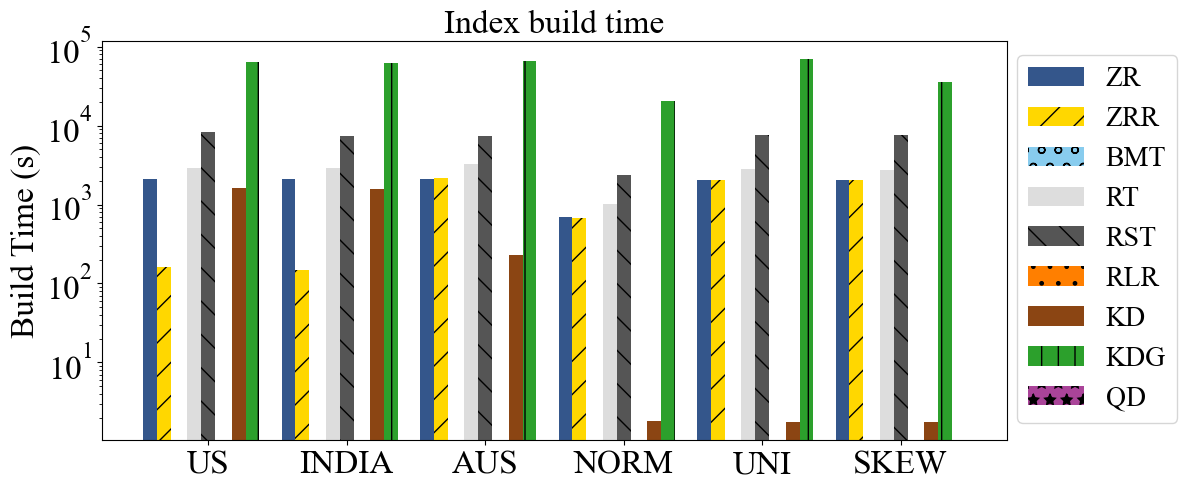

In [124]:
data_names = ["us_100000000", "india_100000000", "australia_100000000", "data_100000000_2_normal_1", "data_100000000_2_uniform_1", "data_100000000_2_skewed_4"]
display_data_names = ["US", "INDIA", "AUS", "NORM", "UNI", "SKEW"]
real_default_range_name_pattern = "_{data_name}_range_1000_2_uniform_1_0.001x0.001"
synthetic_default_range_name_pattern = "_range_1000_2_uniform_1_0.001x0.001"
build_result_name_pattern = "{data_name}{default_range_name}{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']
baselines = ['zorder', 'rankspace_zorder', 'bmtree', 'rtree', 'r_star_tree', 'rlrtree', 'kdtree', 'kdtree_greedy', 'qdtree']
display_baselines = ['ZR', 'ZRR', 'BMT', 'RT', 'RST', 'RLR', 'KD', 'KDG', 'QD']

result = []
utilization_result = []
splits_result = []
adjustments_result = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_results = []
    dataset_utilization_results = []
    dataset_splits_results = []
    dataset_adjustments_results = []
    for data_name in data_names:

        if data_name.startswith("data"):
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
        else:
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
            
        build_result_name = build_result_name_pattern.format(
            data_name=data_name,
            default_range_name=default_range_name,
            suffix=suffix
        )
        res = os.path.join(build_result_path.format(name=baseline), build_result_name)

        tree_property = parse_rtree_properties(res)
        
        # dataset_results.append({
        #     'ElapsedTime': tree_property.ElapsedTime,
        #     'ElapsedBuildTime': tree_property.ElapsedBuildTime,
        #     'ElapsedLearnTime': tree_property.ElapsedLearnTime
        # })
        dataset_results.append(float(tree_property.ElapsedTime / 1e9))
        dataset_utilization_results.append(tree_property.Utilization)
        dataset_splits_results.append(tree_property.Splits)
        dataset_adjustments_results.append(tree_property.Adjustments)

    result.append(dataset_results) 
    utilization_result.append(dataset_utilization_results) 
    splits_result.append(dataset_splits_results) 
    adjustments_result.append(dataset_adjustments_results) 

print(utilization_result)
print(splits_result)
print(adjustments_result)

plot_hist(display_data_names, display_baselines, result, y_label="Build Time (s)", is_log=True, title="Index build time", output_file_paths=
          [folder + "/figs/build.pdf", "../figs/exp/build.pdf"])

#### Point Query

[[200330, 200009, 200192, 200154, 200031, 202609], [200330, 200009, 200192, 200154, 200031, 202609], [0, 0, 0, 0, 0, 0], [200330, 200009, 200192, 200154, 200031, 202609], [200330, 200009, 200192, 200154, 200031, 202609], [0, 0, 0, 0, 0, 0], [200330, 200009, 0, 0, 0, 0], [200330, 200009, 200192, 200154, 200031, 202609], [0, 0, 0, 0, 0, 0]]


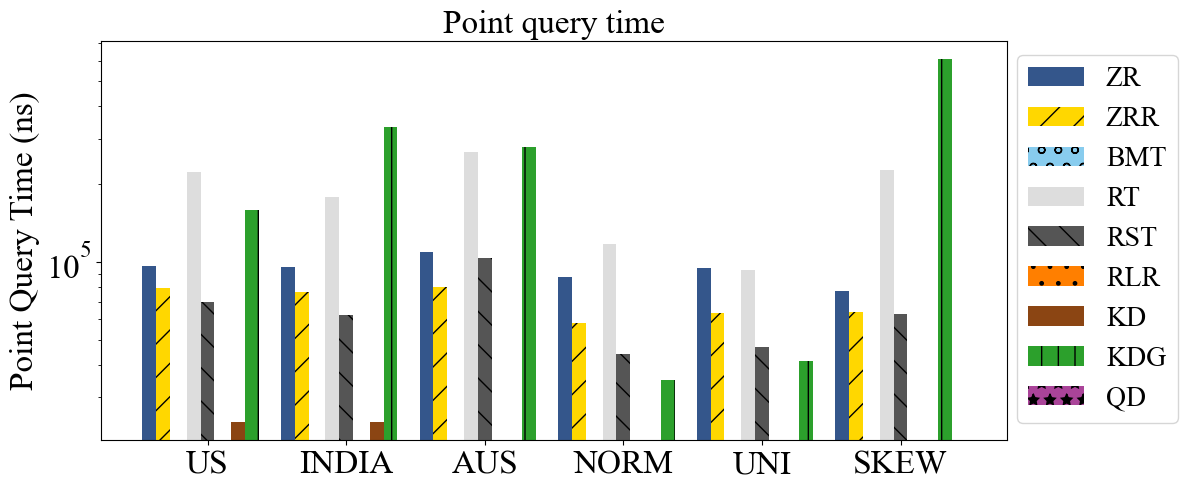

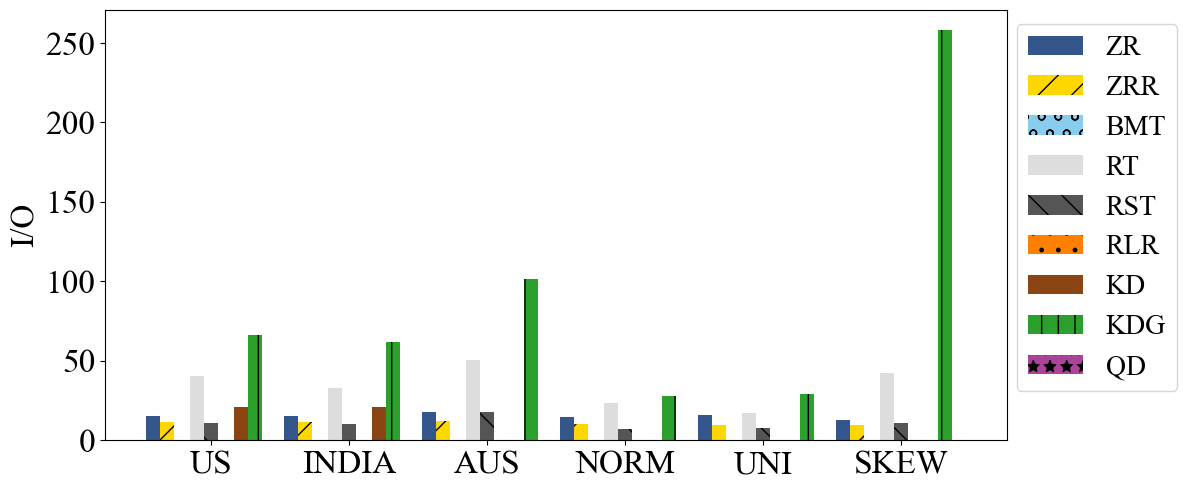

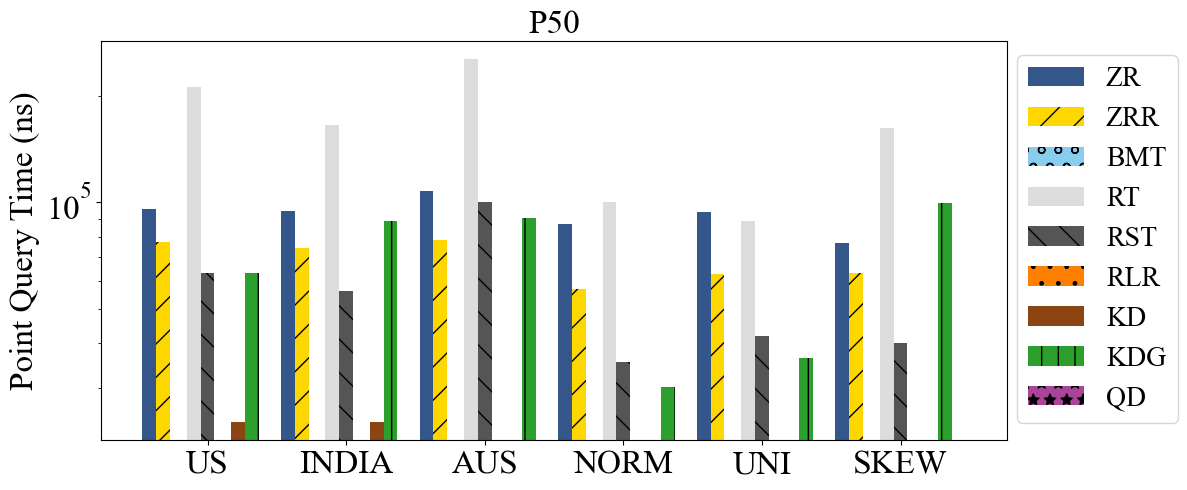

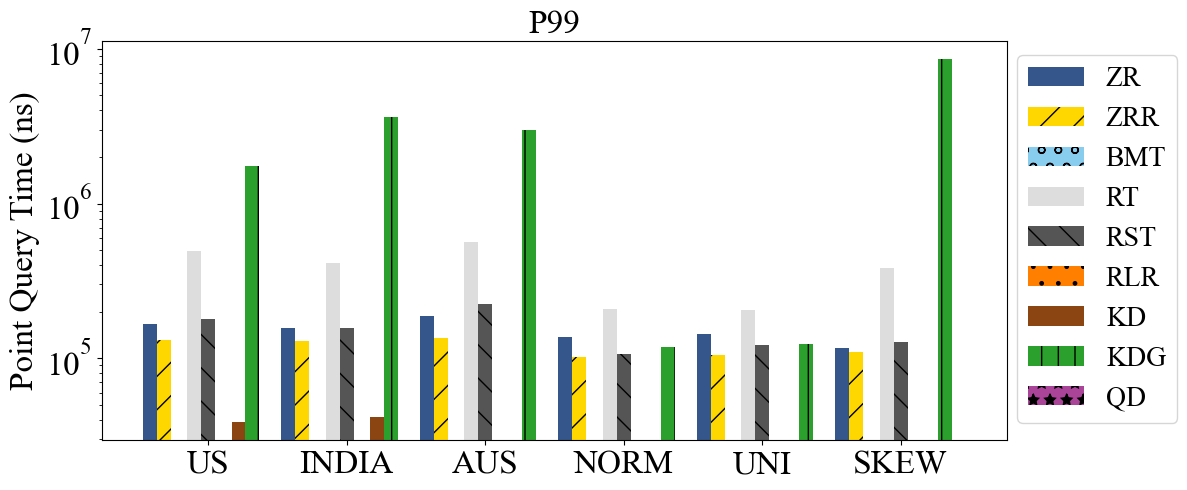

In [125]:
# 1 
# default_range_name = "_{data_name}_range_1000_2_normal_1_0.001x0.001"
real_point_name = "{data_name}_point_200000_2_uniform_1"
synthetic_point_name = "point_200000_{data_name}_2_uniform_1"
point_result_name_pattern = "{data_name}{default_range_name}_{point_name}{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']

result = []
query_result_num = []
IO = []
P99 = []
P50 = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_results = []
    dataset_result_num = []
    dataset_IO = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:

        if data_name.startswith("data"):
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
            point_name = synthetic_point_name.format(data_name=data_name)
        else:
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
            point_name = real_point_name.format(data_name=data_name)
        
        point_result_name = point_result_name_pattern.format(
            data_name=data_name,
            point_name=point_name,
            default_range_name=default_range_name,
            suffix=suffix
        )
        res = os.path.join(point_result_path.format(name=baseline), point_result_name)

        # print(res)
        
        tree_property = parse_rtree_properties(res)

        # self.QueryNum = kwargs.get('Query num', None)
        # self.QueryMean = kwargs.get('Query mean', None)
        # self.QueryVariance = kwargs.get('Query variance', None)
        # self.QueryStdDev = kwargs.get('Query stdDev', None)
        # self.QueryP50 = kwargs.get('Query p50', None)
        # self.QueryP99 = kwargs.get('Query p99', None)
 
        dataset_results.append(float(tree_property.QueryMean))
        dataset_result_num.append(tree_property.QueryResults)
        dataset_IO.append((tree_property.IndexIo + tree_property.LeafIo) / 200000)
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)

    
    result.append(dataset_results) 
    query_result_num.append(dataset_result_num)
    IO.append(dataset_IO)
    P50.append(dataset_P50)
    P99.append(dataset_P99)

print(query_result_num)
# plot_hist(display_data_names, display_baselines, query_result_num, y_label="Result Num", title="Point query result num", output_file_paths=
#           [folder + "/figs/point_result_num.pdf", "../figs/exp/point_result_num.pdf"])

plot_hist(display_data_names, display_baselines, result, y_label="Point Query Time (ns)", title="Point query time", is_log=True, output_file_paths=
          [folder + "/figs/point_query.pdf", "../figs/exp/point_query.pdf"])

plot_hist(display_data_names, display_baselines, IO, y_label="I/O", output_file_paths=
          [folder + "/figs/point_IO.pdf", "../figs/exp/point_IO.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="Point Query Time (ns)", is_log=True, title="P50", output_file_paths=
          [folder + "/figs/point_query_P50.pdf", "../figs/exp/point_query_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="Point Query Time (ns)", is_log=True, title="P99", output_file_paths=
          [folder + "/figs/point_query_P99.pdf", "../figs/exp/point_query_P99.pdf"])

#### Range Query

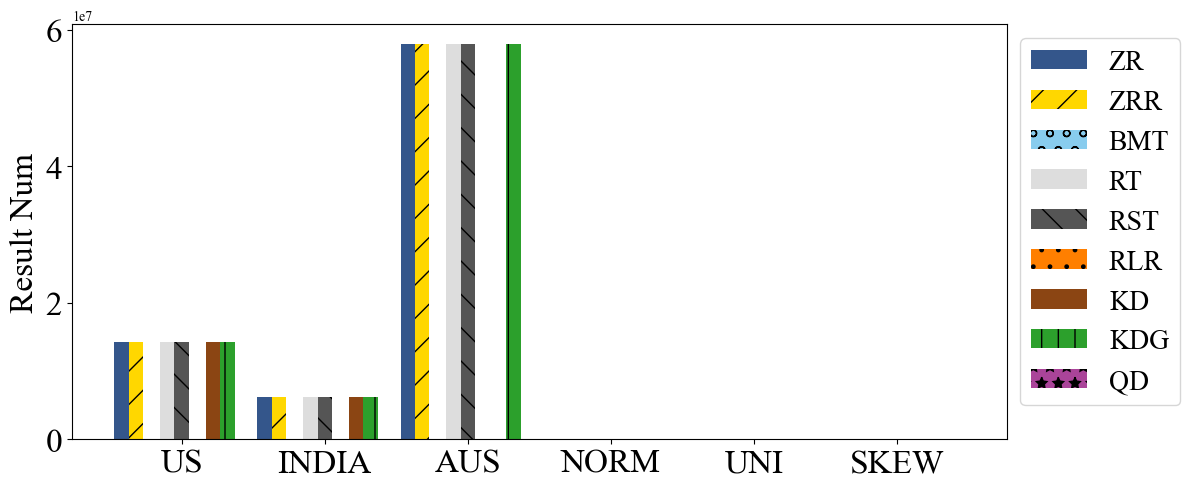

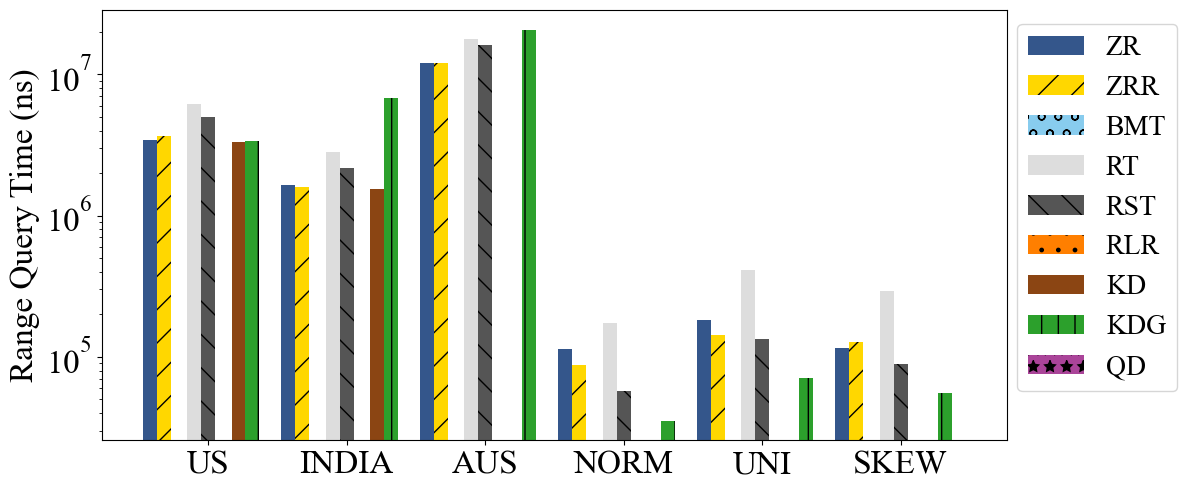

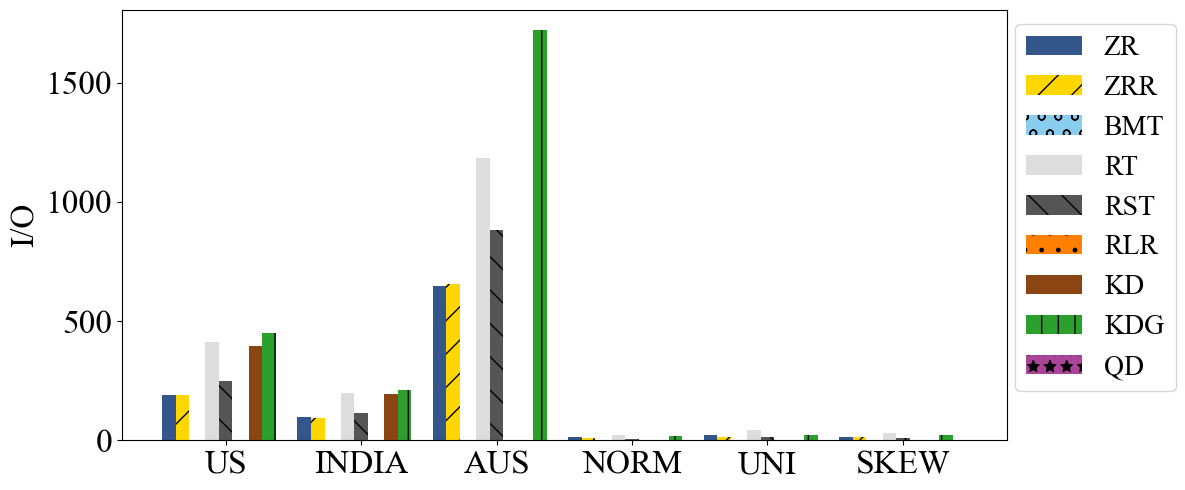

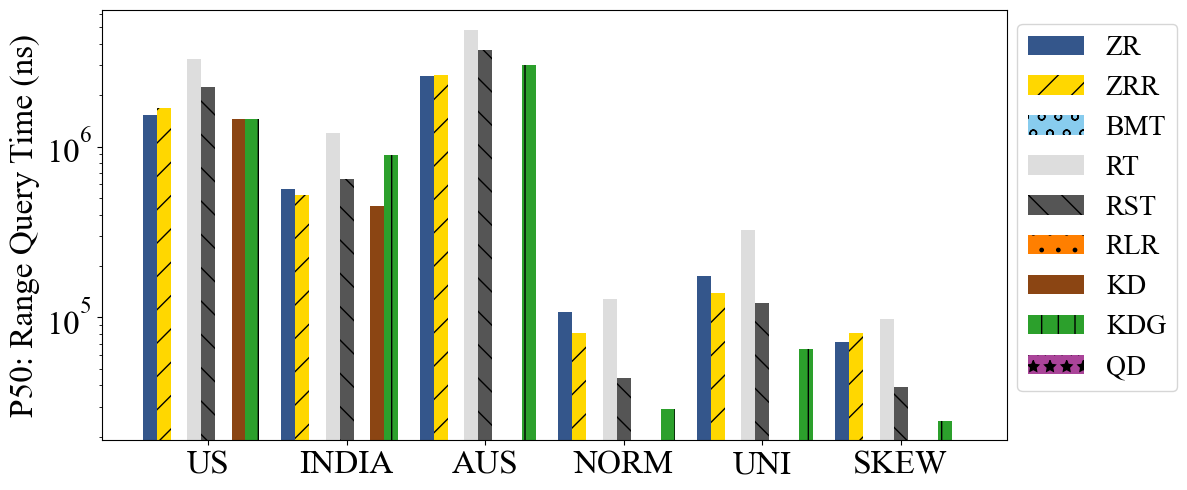

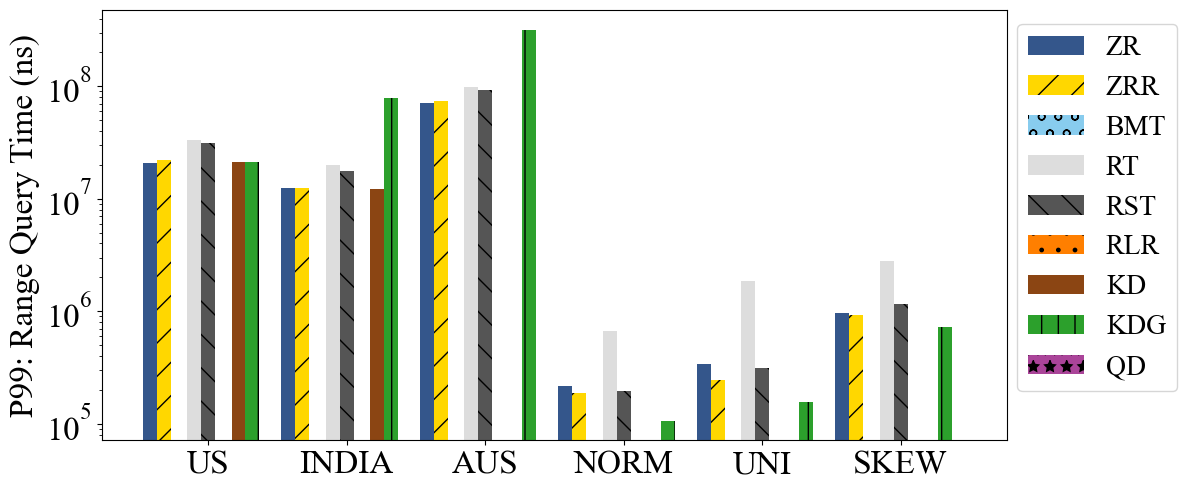

In [126]:
real_range_name_pattern = "_{data_name}_range_1000_2_uniform_1_0.001x0.001"
synthetic_range_name_pattern = "_range_1000_2_uniform_1_0.001x0.001"
range_result_name_pattern = "{data_name}{range_name}{suffix}.txt"
result = []
IO = []

P99 = []
P50 = []

query_result_num = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_results = []
    dataset_result_num = []
    dataset_IO = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:

        if data_name.startswith("data"):
            range_name = synthetic_range_name_pattern
        else:
            range_name=real_range_name_pattern.format(data_name=data_name)
        
        range_result_name = range_result_name_pattern.format(
            data_name=data_name,
            range_name=range_name,
            suffix=suffix
        )
        res = os.path.join(range_result_path.format(name=baseline), range_result_name)
        
        tree_property = parse_rtree_properties(res)

        dataset_results.append(float(tree_property.QueryMean))
        dataset_result_num.append(tree_property.QueryResults)
        dataset_IO.append((tree_property.IndexIo + tree_property.LeafIo)/1000)
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)
        
    result.append(dataset_results) 
    query_result_num.append(dataset_result_num) 
    IO.append(dataset_IO)
    P50.append(dataset_P50)
    P99.append(dataset_P99)

plot_hist(display_data_names, display_baselines, query_result_num, y_label="Result Num", output_file_paths=
          [folder + "/figs/range_query_result_num.pdf", "../figs/exp/range_query_result_num.pdf"])

# plot_hist(data_names, baselines, result)
plot_hist(display_data_names, display_baselines, result, y_label="Range Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/range_query_time.pdf", "../figs/exp/range_query_time.pdf"])

plot_hist(display_data_names, display_baselines, IO, y_label="I/O", output_file_paths=
          [folder + "/figs/range_query_IO.pdf", "../figs/exp/range_query_IO.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Range Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/range_query_P50.pdf", "../figs/exp/range_query_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Range Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/range_query_P99.pdf", "../figs/exp/range_query_P99.pdf"])

#### knn Query

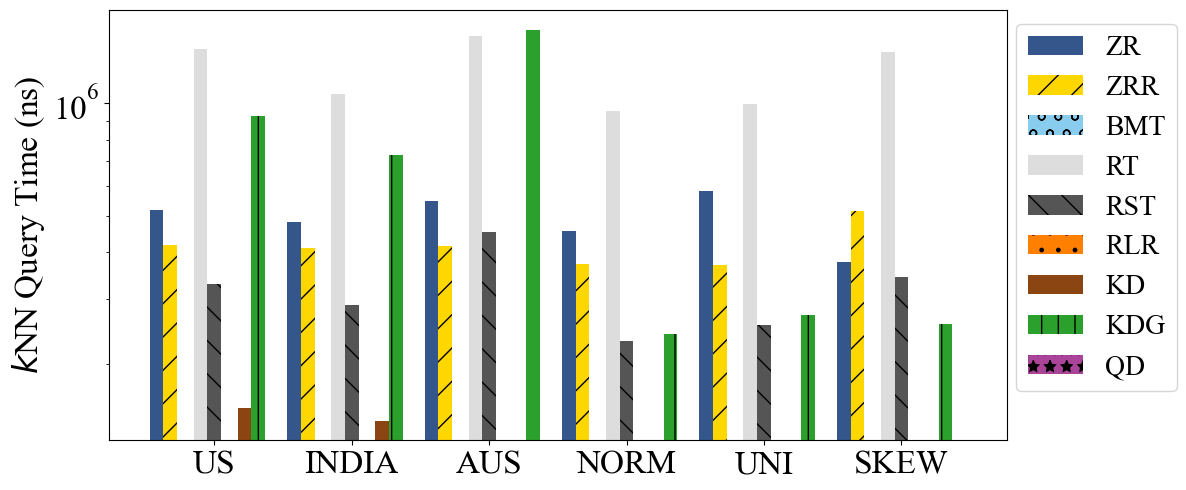

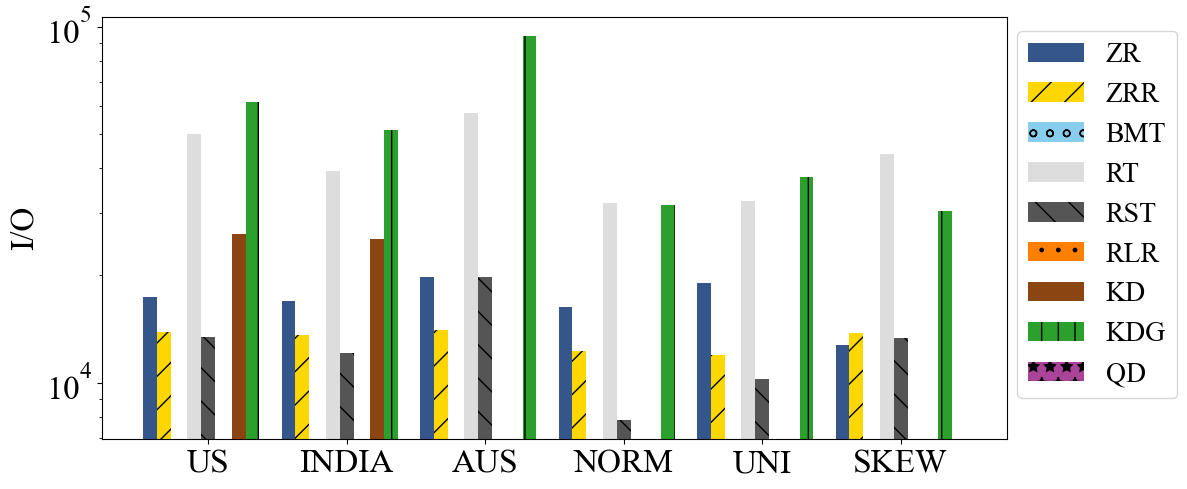

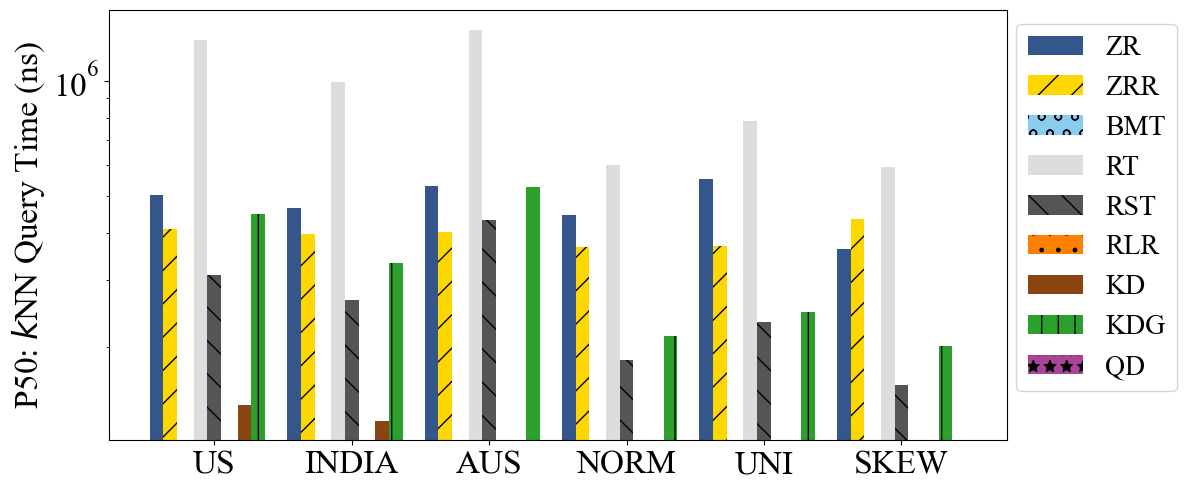

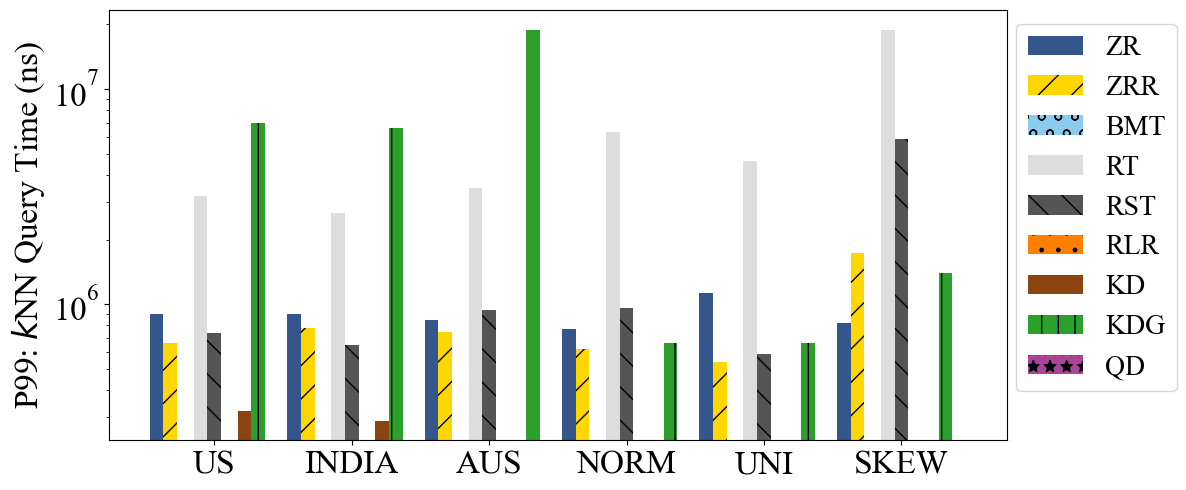

In [127]:
# 1 
data_name = "OSM_10000"
k=25
real_knn_name = "{data_name}_knn_1000_2_uniform_1"
synthetic_knn_name = "knn_1000_2_uniform_1"
knn_result_name_pattern = "{data_name}{default_range_name}_{knn_name}_k_{k}{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']

result = []
result_num = []
IO = []

P99 = []
P50 = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_results = []
    dataset_result_num = []
    dataset_IO = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:

        if data_name.startswith("data"):
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
            knn_name = synthetic_knn_name
        else:
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
            knn_name = real_knn_name.format(data_name=data_name)
        
        knn_result_name = knn_result_name_pattern.format(
            data_name=data_name,
            knn_name=knn_name,
            default_range_name=default_range_name.format(data_name=data_name) if baseline in special_baselines else '',
            suffix=suffix,
            k=k
        )
        res = os.path.join(knn_result_path.format(name=baseline), knn_result_name)
        
        tree_property = parse_rtree_properties(res)

        dataset_results.append(float(tree_property.QueryMean))
        dataset_result_num.append(tree_property.QueryResults)
        dataset_IO.append(tree_property.IndexIo + tree_property.LeafIo)
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)
        
    result.append(dataset_results) 
    result_num.append(dataset_result_num) 
    IO.append(dataset_IO) 
    P50.append(dataset_P50)
    P99.append(dataset_P99)


# plot_hist(display_data_names, display_baselines, result_num, y_label="Result Num", output_file_paths=
#           [folder + "/figs/knn_num.pdf", "../figs/exp/knn_num.pdf"])

plot_hist(display_data_names, display_baselines, result, y_label="$k$NN Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/knn_query_time.pdf", "../figs/exp/knn_query_time.pdf"])

plot_hist(display_data_names, display_baselines, IO, y_label="I/O", is_log=True, output_file_paths=
          [folder + "/figs/knn_query_IO.pdf", "../figs/exp/knn_query_IO.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: $k$NN Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/knn_query_P50.pdf", "../figs/exp/knn_query_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: $k$NN Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/knn_query_P99.pdf", "../figs/exp/knn_query_P99.pdf"])

### Write only

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


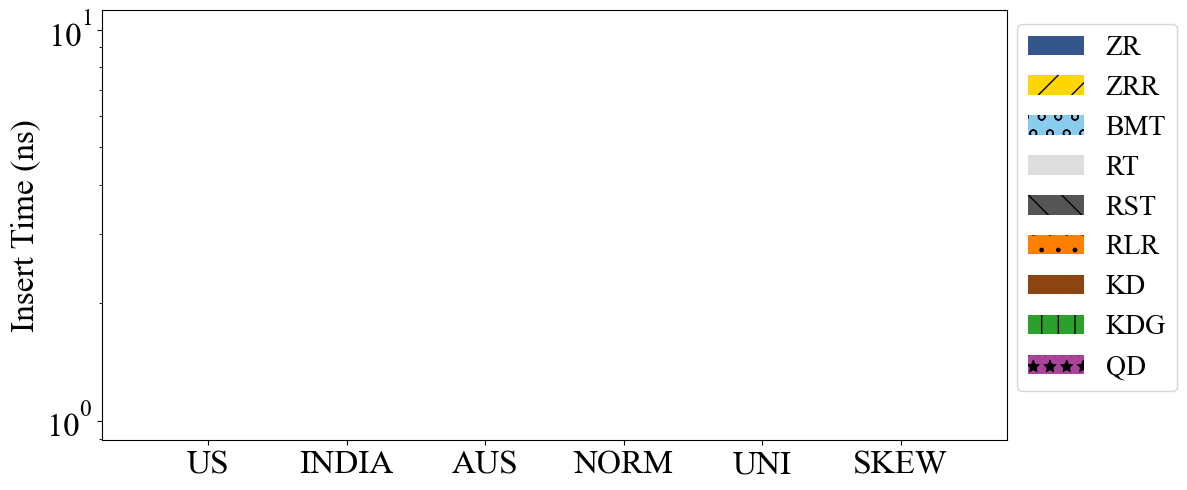

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


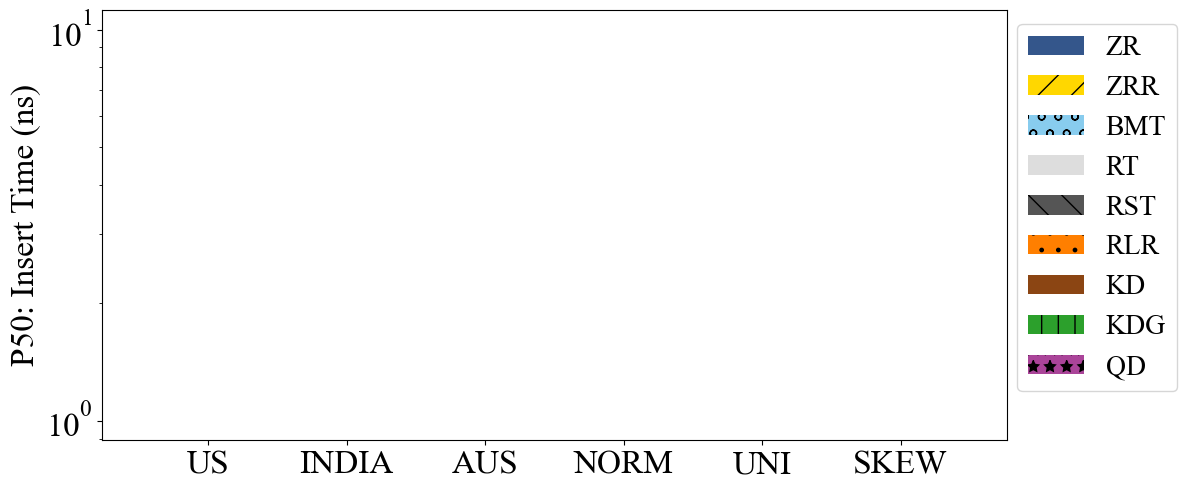

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


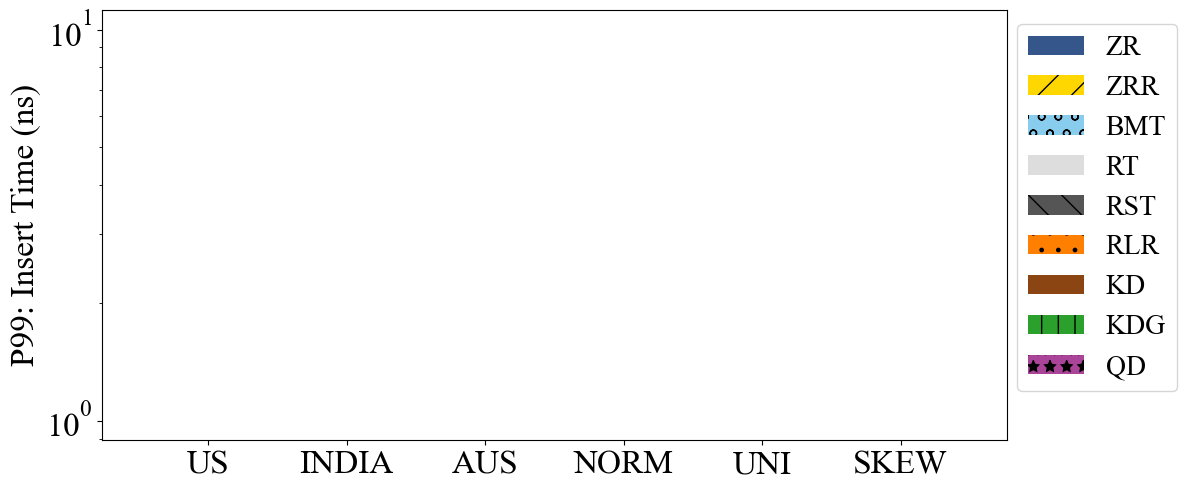

In [128]:
# 1 
data_name = "OSM_10000"
default_range_name = "_{data_name}_range_1000_2_uniform_1_0.001x0.001"
synthetic_insert_name = "insert_1000_2_uniform_1"
real_insert_name = "{data_name}_insert_1000_2_uniform_1"
insert_result_name_pattern = "{data_name}{default_range_name}_{insert_name}{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']
result = []
IO = []
result_num = []

P99 = []
P50 = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_results = []
    dataset_result_num = []
    dataset_IO = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:        

        if data_name.startswith("data"):
            insert_name = synthetic_insert_name
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
        else:
            insert_name=real_insert_name.format(data_name=data_name) 
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
        
        insert_result_name = insert_result_name_pattern.format(
            data_name=data_name,
            insert_name=insert_name,
            default_range_name=default_range_name,
            suffix=suffix
        )
        res = os.path.join(insert_result_path.format(name=baseline), insert_result_name)
        
        tree_property = parse_rtree_properties(res)

        dataset_results.append(float(tree_property.InsertMean))
        dataset_result_num.append(tree_property.QueryResults)
        dataset_IO.append(tree_property.IndexIo + tree_property.LeafIo)
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)

    result.append(dataset_results)
    result_num.append(dataset_result_num)
    IO.append(dataset_IO)
    P50.append(dataset_P50)
    P99.append(dataset_P99)

plot_hist(display_data_names, display_baselines, result, y_label="Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_only.pdf", "../figs/exp/write_only.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_only_P50.pdf", "../figs/exp/write_only_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_only_P99.pdf", "../figs/exp/write_only_P99.pdf"])

# plot_hist(display_data_names, display_baselines, result_num, y_label="Result Num", output_file_path="../figs/exp/write_only_num.pdf")
# plot_hist(display_data_names, display_baselines, IO, y_label="I/O", output_file_path="../figs/exp/write_only_IO.pdf")

### Balanced

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


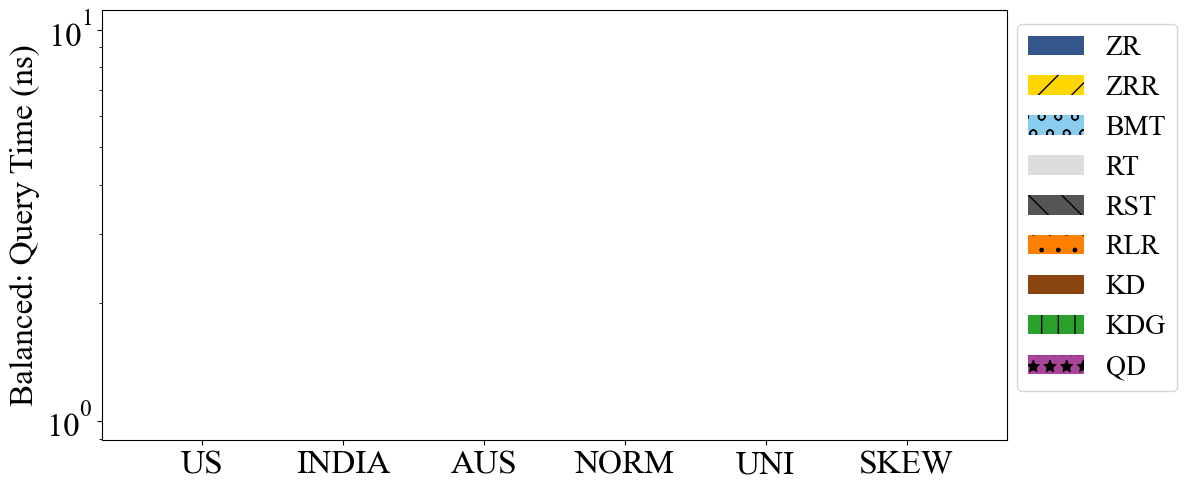

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


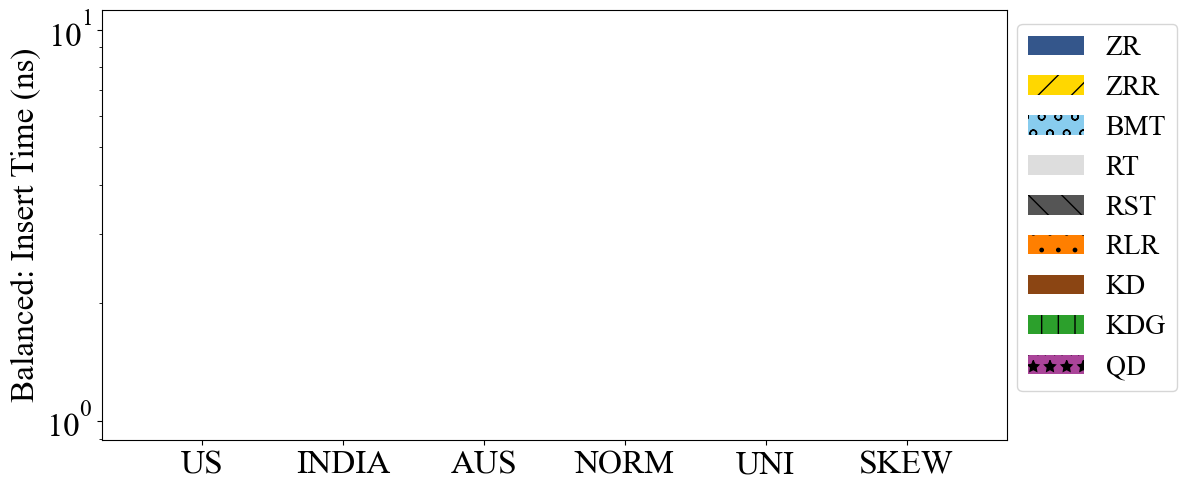

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


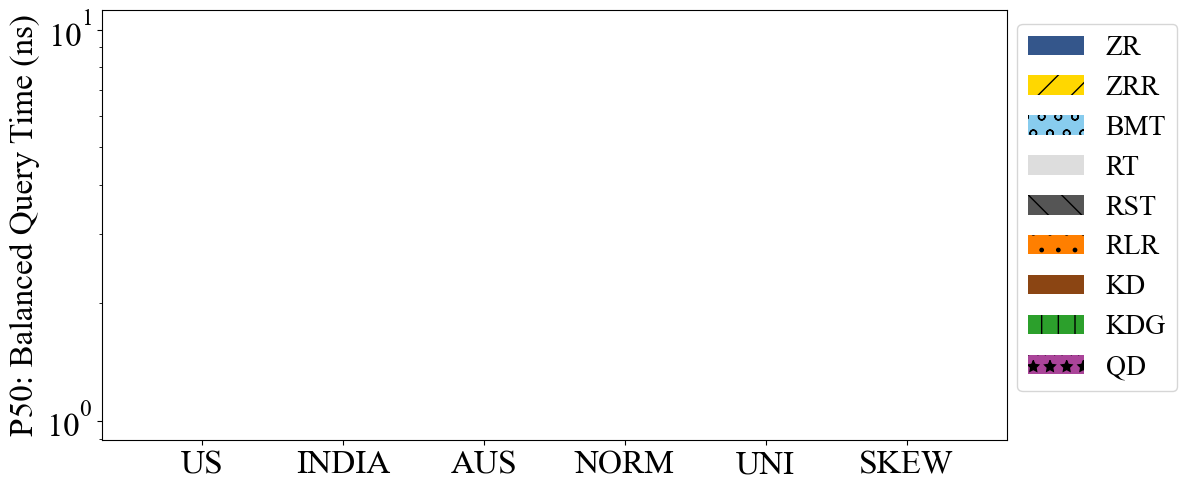

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


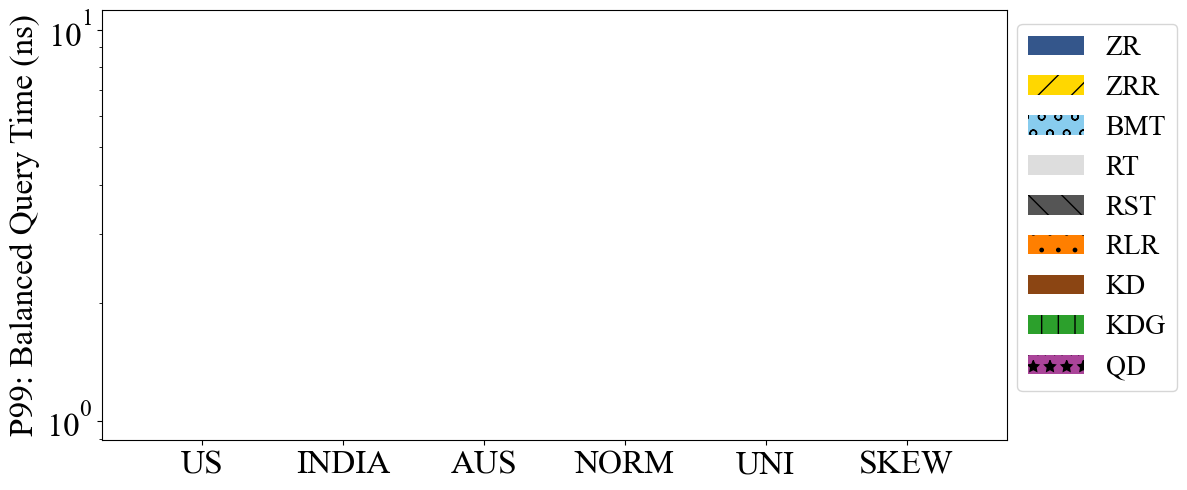

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


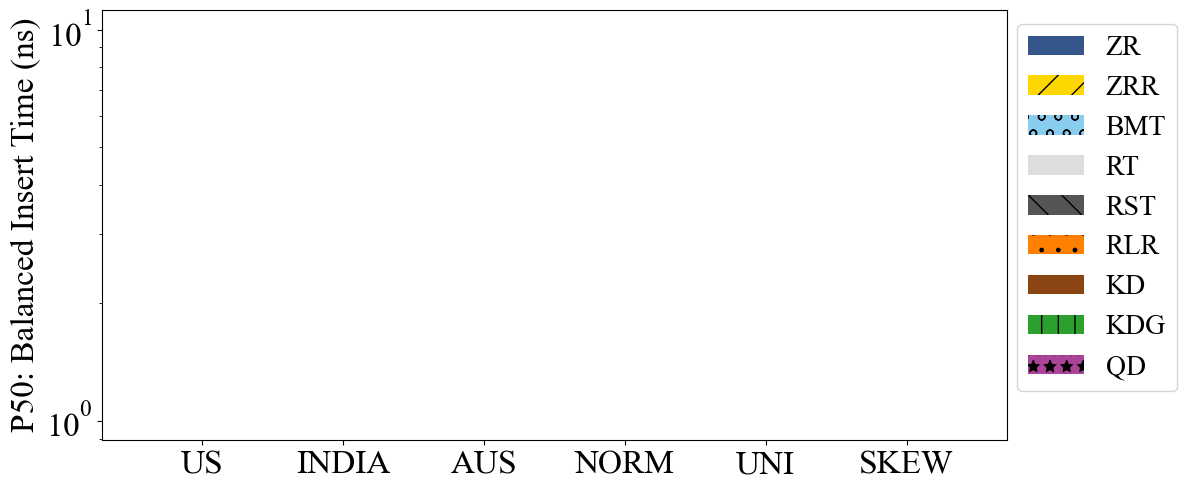

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


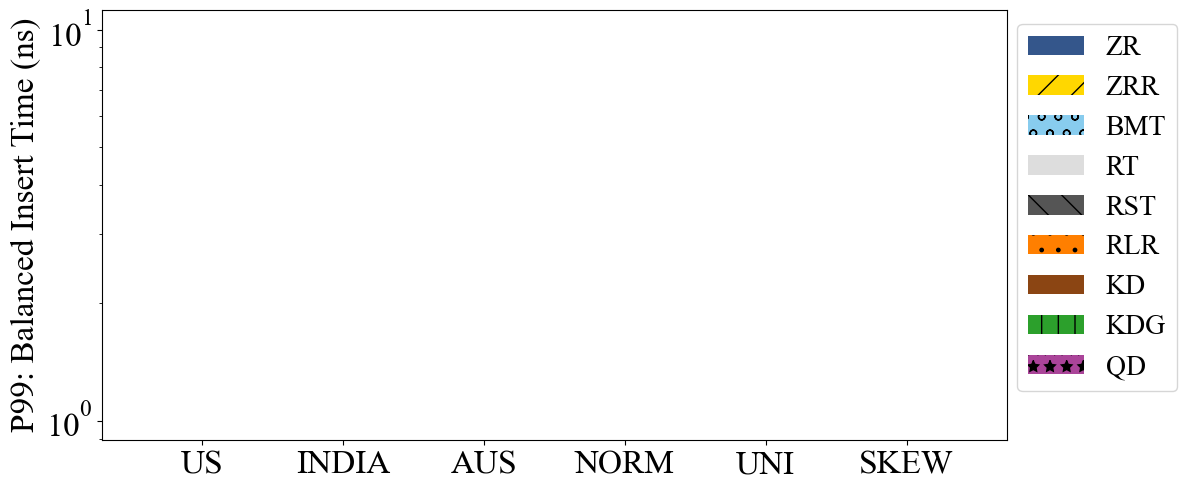

In [102]:
# 1 
data_name = "OSM_10000"
default_range_name = "_{data_name}_range_1000_2_uniform_1_0.001x0.001_2_uniform_1"
synthetic_insert_point_name = "insert_point_1000_{data_name}_2_uniform_1"
real_insert_point_name = "{data_name}_insert_point_1000_2_uniform_1"
insert_point_result_name_pattern = "{data_name}{default_range_name}_{insert_point_name}_10_10{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']


insert_result = []
query_result = []

P99 = []
P50 = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_query_results = []
    dataset_insert_results = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:  

        if data_name.startswith("data"):
            insert_point_name = synthetic_insert_point_name.format(data_name=data_name) 
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
        else:
            insert_point_name=real_insert_point_name.format(data_name=data_name) 
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
        
            
        insert_point_result_name = insert_point_result_name_pattern.format(
            data_name=data_name,
            insert_point_name=insert_point_name,
            default_range_name=default_range_name,
            suffix=suffix
        )
        res = os.path.join(insert_point_result_path.format(name=baseline), insert_point_result_name)
        tree_property = parse_rtree_properties(res)

        dataset_query_results.append(float(tree_property.QueryMean))
        dataset_insert_results.append(float(tree_property.InsertMean))
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)
        
    query_result.append(dataset_query_results) 
    insert_result.append(dataset_insert_results) 
    P50.append(dataset_P50)
    P99.append(dataset_P99)

plot_hist(display_data_names, display_baselines, query_result, y_label="Balanced: Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/balanced_query_time.pdf", "../figs/exp/balanced_query_time.pdf"])
plot_hist(display_data_names, display_baselines, insert_result, y_label="Balanced: Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/balanced_insert_time.pdf", "../figs/exp/balanced_insert_time.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Balanced Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/balanced_query_time_P50.pdf", "../figs/exp/balanced_query_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Balanced Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/balanced_query_time_P99.pdf", "../figs/exp/balanced_query_time_P99.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Balanced Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/balanced_insert_time_P50.pdf", "../figs/exp/balanced_insert_time_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Balanced Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/balanced_insert_time_P99.pdf", "../figs/exp/balanced_insert_time_P99.pdf"])

### Write heavy

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


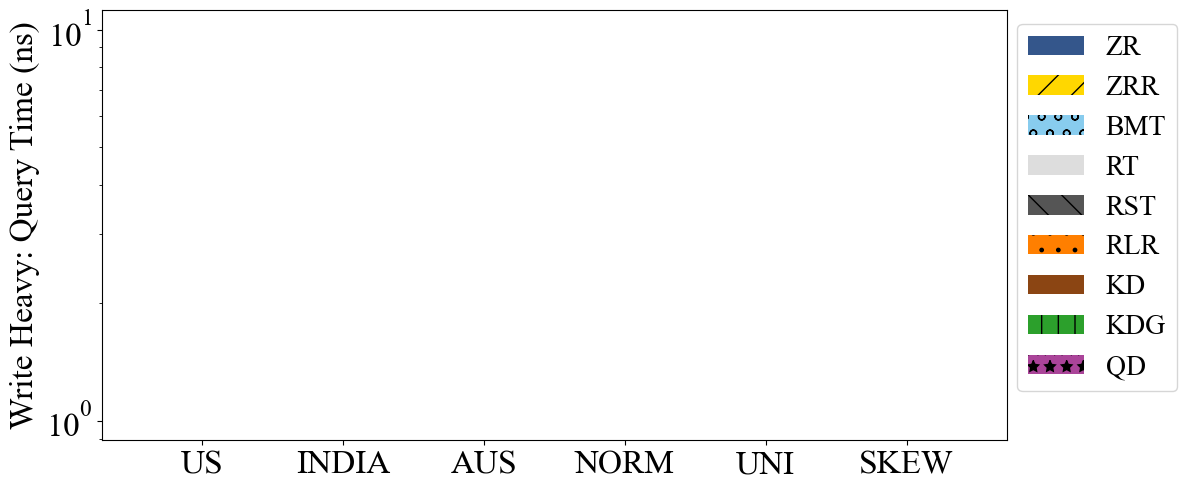

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


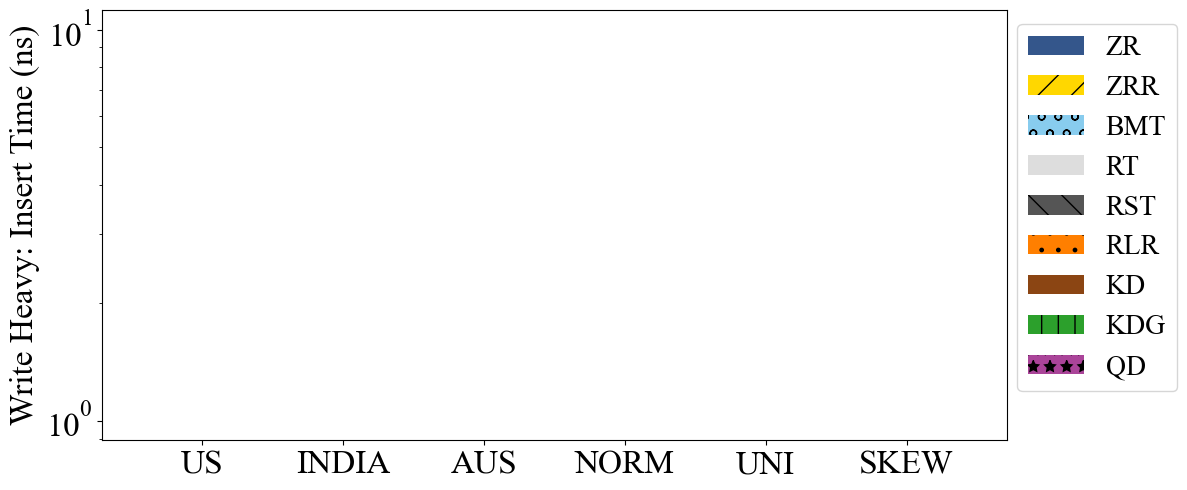

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


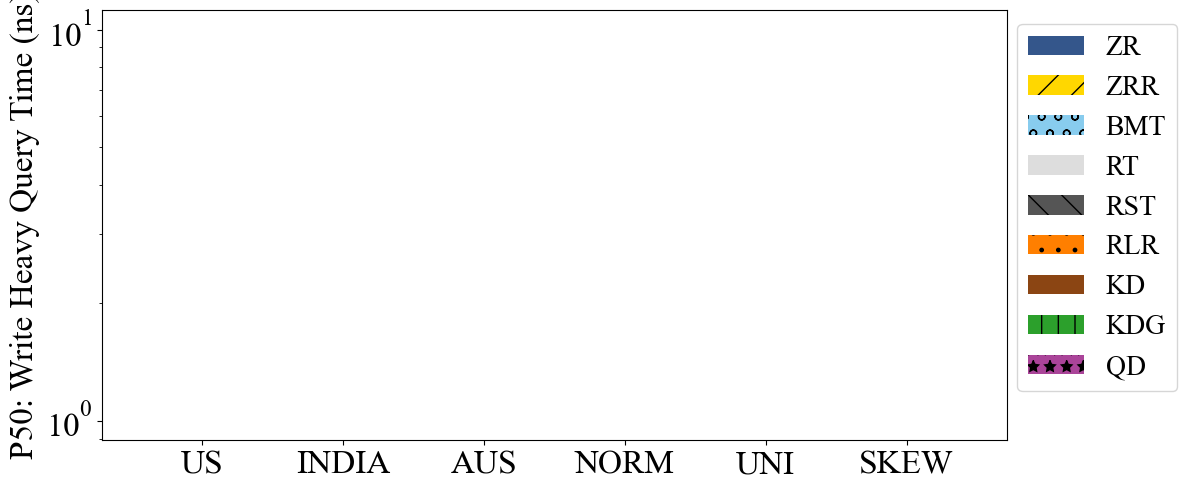

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


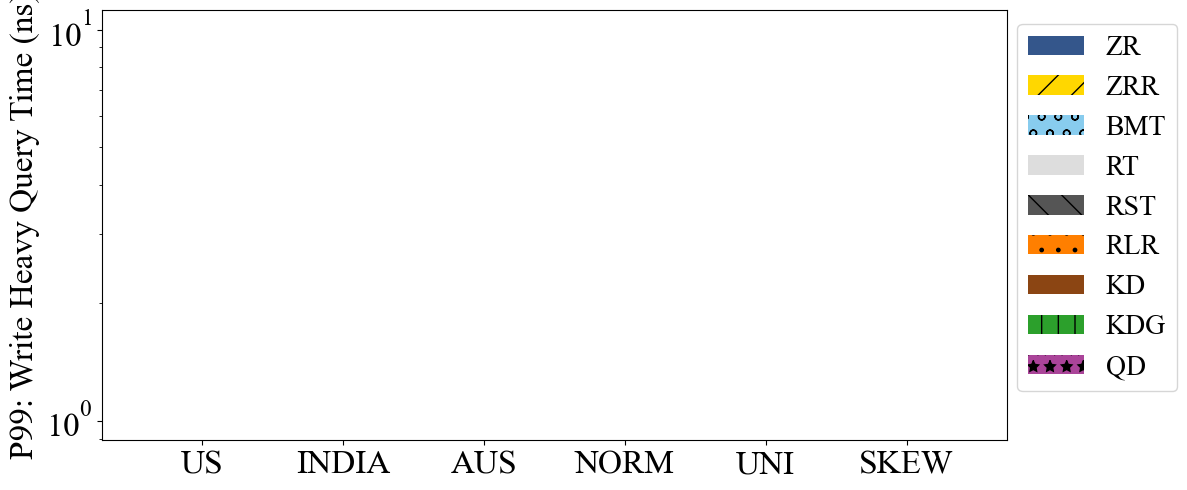

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


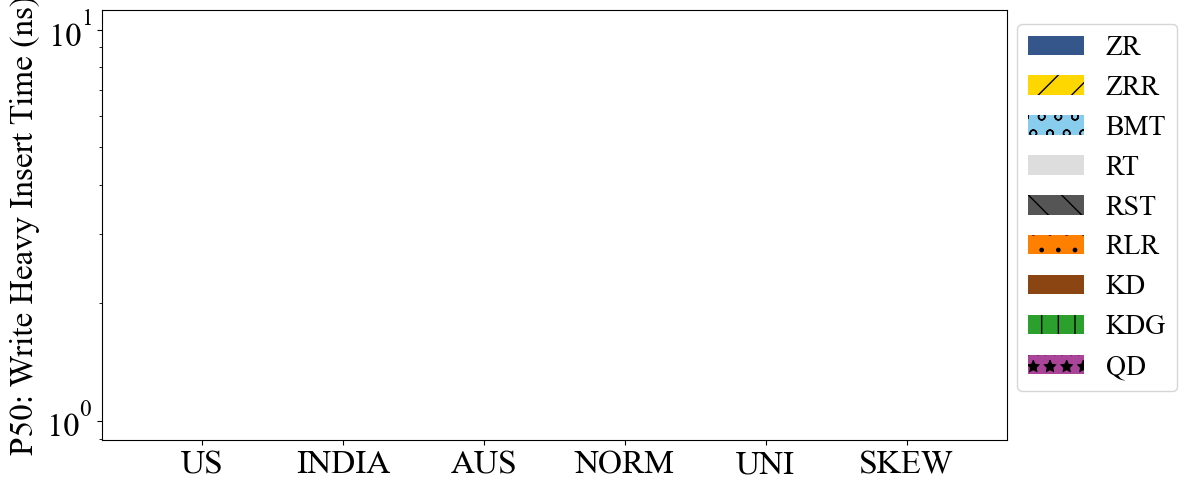

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/249663171.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


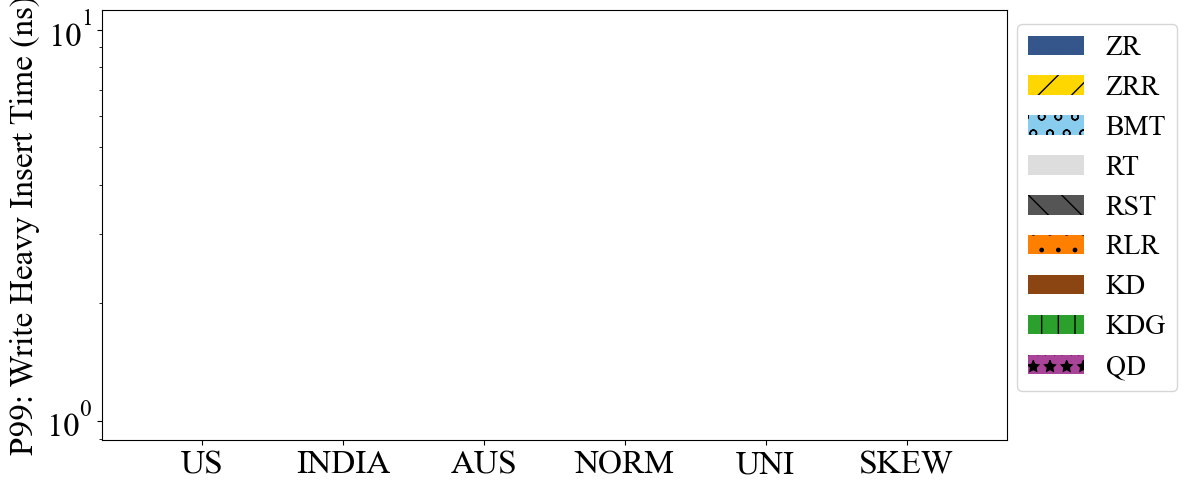

In [103]:
# 1 
insert_point_result_name_pattern = "{data_name}{default_range_name}_{insert_point_name}_18_2{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']

insert_result = []
query_result = []

P99 = []
P50 = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_query_results = []
    dataset_insert_results = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:  
            
        if data_name.startswith("data"):
            insert_point_name = synthetic_insert_point_name.format(data_name=data_name) 
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
        else:
            insert_point_name=real_insert_point_name.format(data_name=data_name) 
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
        
            
        insert_point_result_name = insert_point_result_name_pattern.format(
            data_name=data_name,
            insert_point_name=insert_point_name,
            default_range_name=default_range_name,
            suffix=suffix
        )
        res = os.path.join(insert_point_result_path.format(name=baseline), insert_point_result_name)
        tree_property = parse_rtree_properties(res)

        dataset_query_results.append(float(tree_property.QueryMean))
        dataset_insert_results.append(float(tree_property.InsertMean))
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)
        
    query_result.append(dataset_query_results) 
    insert_result.append(dataset_insert_results) 
    P50.append(dataset_P50)
    P99.append(dataset_P99)

plot_hist(display_data_names, display_baselines, query_result, y_label="Write Heavy: Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_heavy_query_time.pdf", "../figs/exp/write_heavy_query_time.pdf"])
plot_hist(display_data_names, display_baselines, insert_result, y_label="Write Heavy: Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_heavy_insert_time.pdf", "../figs/exp/write_heavy_insert_time.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Write Heavy Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_heavy_query_time_P50.pdf", "../figs/exp/write_heavy_query_time_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Write Heavy Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_heavy_query_time_P99.pdf", "../figs/exp/write_heavy_query_time_P99.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Write Heavy Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_heavy_insert_time_P50.pdf", "../figs/exp/write_heavy_insert_time_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Write Heavy Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/write_heavy_insert_time_P99.pdf", "../figs/exp/write_heavy_insert_time_P99.pdf"])


### Read heavy

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


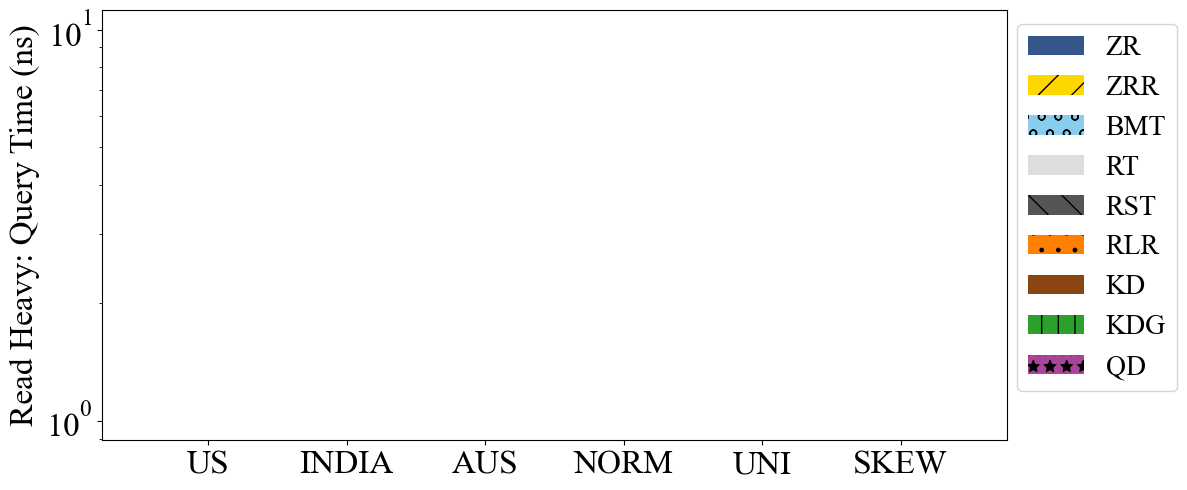

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


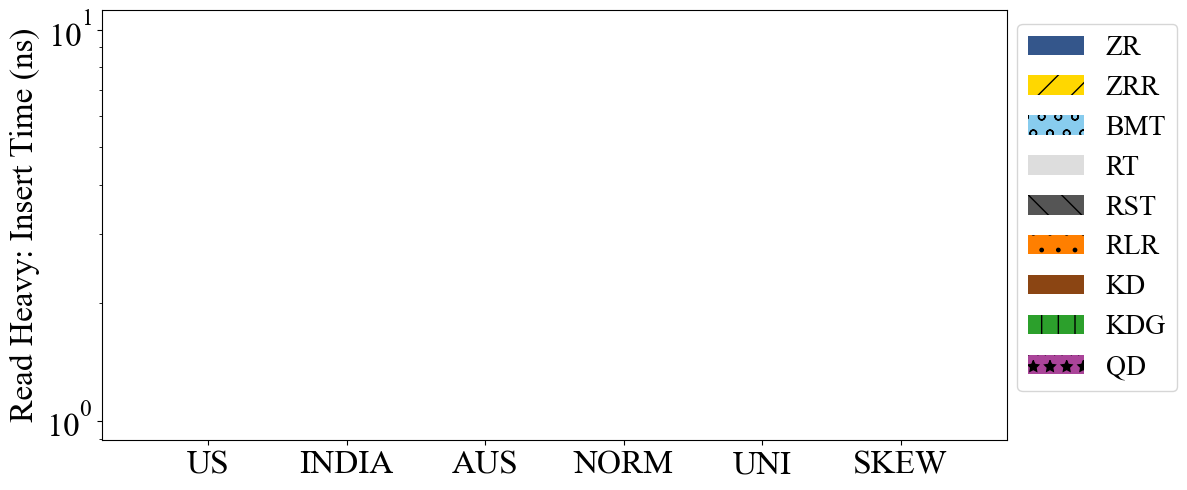

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


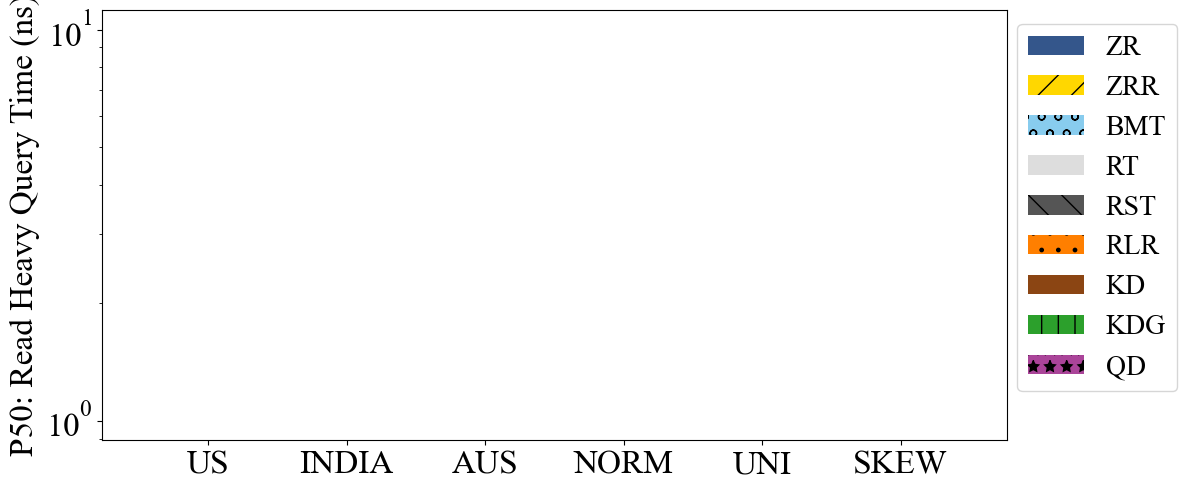

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


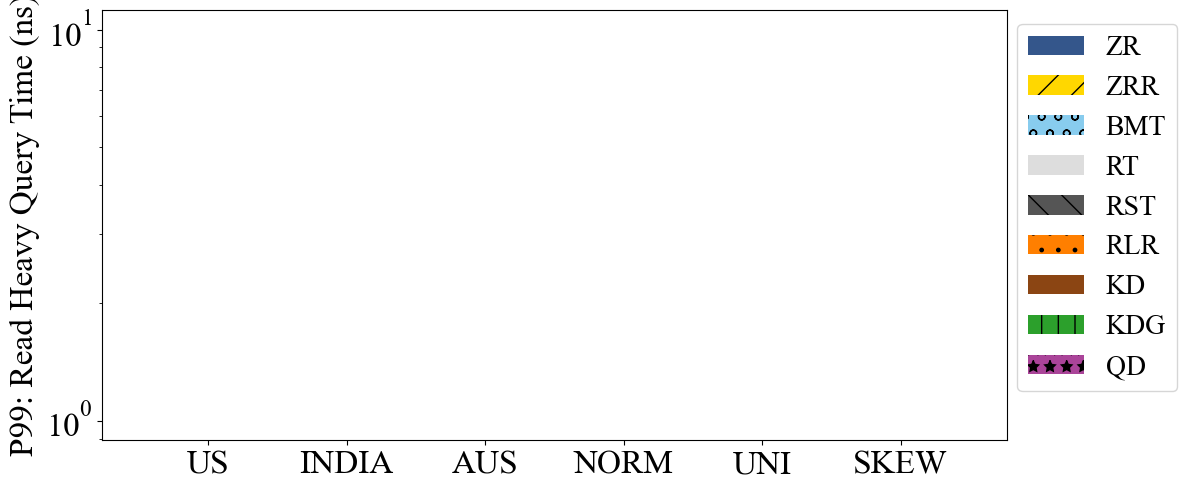

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


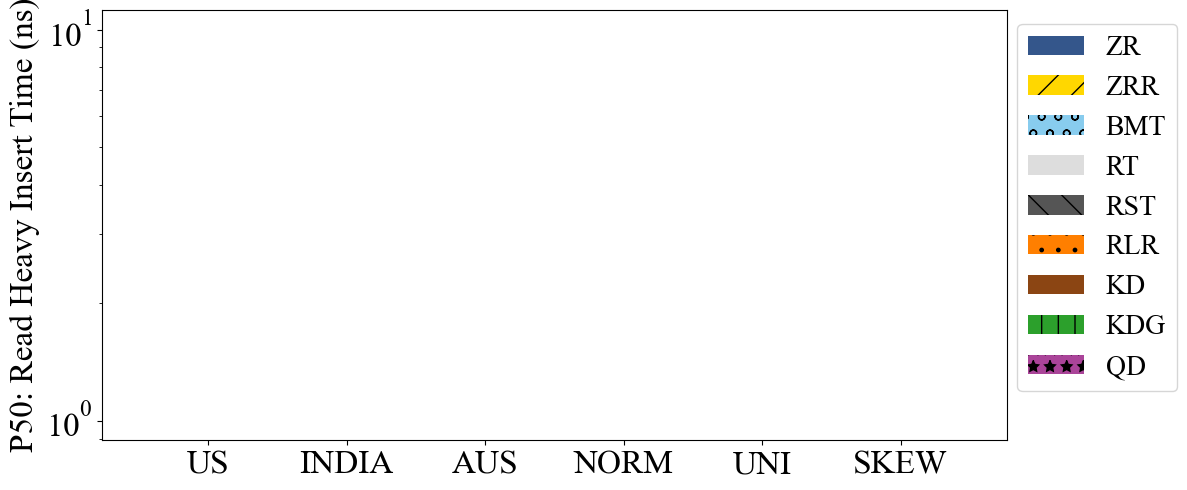

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_96764/1839596625.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


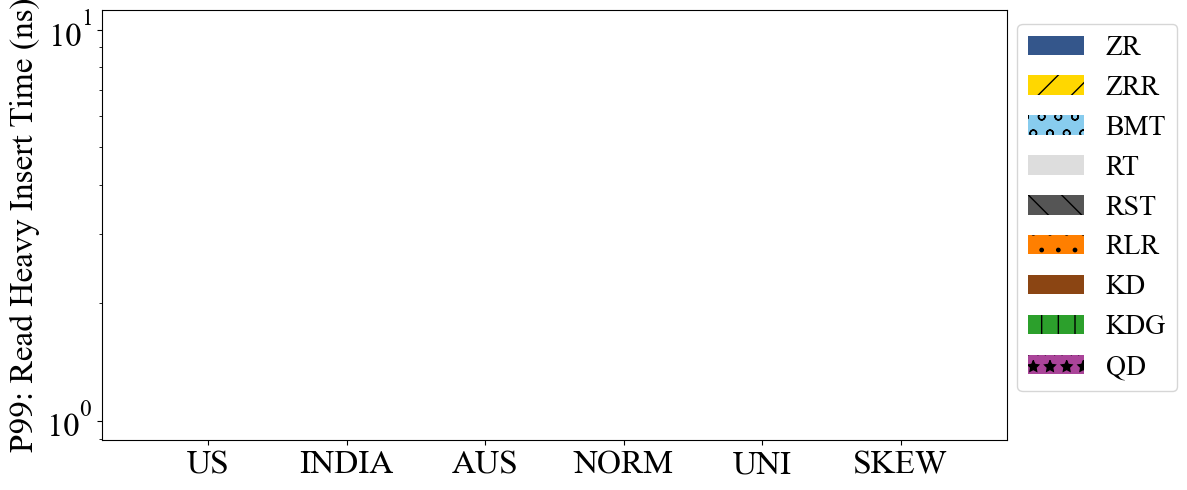

In [129]:
# 1 
insert_point_result_name_pattern = "{data_name}{default_range_name}_{insert_point_name}_2_18{suffix}.txt"
special_baselines = ['bmtree', 'kdtree_greedy', 'rlrtree', 'qdtree']

insert_result = []
query_result = []

P99 = []
P50 = []

for baseline in baselines:
    suffix = baseline_suffix[baseline]
    dataset_query_results = []
    dataset_insert_results = []
    dataset_P50 = []
    dataset_P99 = []
    for data_name in data_names:  
            
        if data_name.startswith("data"):
            insert_point_name = synthetic_insert_point_name.format(data_name=data_name) 
            default_range_name = synthetic_default_range_name_pattern if baseline in special_baselines else ''
        else:
            insert_point_name=real_insert_point_name.format(data_name=data_name) 
            default_range_name=real_default_range_name_pattern.format(data_name=data_name) if baseline in special_baselines else ''
        
            
        insert_point_result_name = insert_point_result_name_pattern.format(
            data_name=data_name,
            insert_point_name=insert_point_name,
            default_range_name=default_range_name,
            suffix=suffix
        )
        res = os.path.join(insert_point_result_path.format(name=baseline), insert_point_result_name)
        tree_property = parse_rtree_properties(res)

        dataset_query_results.append(float(tree_property.QueryMean))
        dataset_insert_results.append(float(tree_property.InsertMean))
        dataset_P50.append(tree_property.QueryP50)
        dataset_P99.append(tree_property.QueryP99)
        
    query_result.append(dataset_query_results) 
    insert_result.append(dataset_insert_results) 
    P50.append(dataset_P50)
    P99.append(dataset_P99)

plot_hist(display_data_names, display_baselines, query_result, y_label="Read Heavy: Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/read_heavy_query_time.pdf", "../figs/exp/read_heavy_query_time.pdf"])
plot_hist(display_data_names, display_baselines, insert_result, y_label="Read Heavy: Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/read_heavy_insert_time.pdf", "../figs/exp/read_heavy_insert_time.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Read Heavy Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/read_heavy_query_time_P50.pdf", "../figs/exp/read_heavy_query_time_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Read Heavy Query Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/read_heavy_query_time_P99.pdf", "../figs/exp/read_heavy_query_time_P99.pdf"])

plot_hist(display_data_names, display_baselines, P50, y_label="P50: Read Heavy Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/read_heavy_insert_time_P50.pdf", "../figs/exp/read_heavy_insert_time_P50.pdf"])

plot_hist(display_data_names, display_baselines, P99, y_label="P99: Read Heavy Insert Time (ns)", is_log=True, output_file_paths=
          [folder + "/figs/read_heavy_insert_time_P99.pdf", "../figs/exp/read_heavy_insert_time_P99.pdf"])
